# Apply Multinomial Naive Bayes on Amazon Fine Food Reviews


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


### Objective:
####     Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




### NOTE:-
#### ------------->>HERE WE HAVE TAKEN ONLY 100K POINTS.
#### ------------->>WE ARE APPLYING MULTINOMIAL NAIVE BAYES ON BOW AND TF-IDF VECTORIZATION 


# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [81]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [82]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [83]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [84]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [85]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [86]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [87]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [88]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [89]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [90]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [91]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [92]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [93]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [94]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [95]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [96]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [97]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [98]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [99]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [100]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [127]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [128]:
#code for BRUTE version
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:50<00:00, 1721.81it/s]


In [114]:
preprocessed_reviews[1000]

'candy blocks nice visual lego birthday party candy little taste little lbs bought eaten threw rest away would not buy candy'

# [4] Featurization

## [4.1] BAG OF WORDS

# Applying Multinomial Naive Bayes

In [116]:
# ============================== loading libraries ===========================================
from sklearn.metrics import roc_curve,auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score
# =============================================================================================

### [5.1] Applying Multinomial Naive Bayes on BOW,<font color='red'> SET 1</font>

In [146]:

from sklearn.model_selection import train_test_split

# split the data set into train and test
X_1, X_test, y_1, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)

In [200]:


#code for BRUTE version
count_vect = CountVectorizer(min_df = 10) 
Xbow_tr = count_vect.fit_transform(X_tr)
Xbow_test = count_vect.transform(X_test)
Xbow_cv = count_vect.transform(X_cv)
print("the type of count vectorizer :",type(X_tr))
print("the shape of out text BOW vectorizer : ",Xbow_tr.get_shape())
print("the number of unique words :", Xbow_tr.get_shape()[1])

the type of count vectorizer : <class 'list'>
the shape of out text BOW vectorizer :  (43008, 8210)
the number of unique words : 8210


In [201]:
# Creating alpha values in the range from 10^-4 to 10^4
neighbors = []
i = 0.0001
while(i<=10000):
    neighbors.append(np.round(i,4))
    i *= 4
auc1=[]
auc2=[]

for k in neighbors:
    # instantiate learning model (k)
    mnb = MultinomialNB(alpha = k)

    # fitting the model on crossvalidation train
    mnb.fit(Xbow_tr, y_tr)
    
    probs = mnb.predict_proba(Xbow_tr)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
    #knn.fit(Xbow_cv, y_cv)
    probs = mnb.predict_proba(Xbow_cv)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)

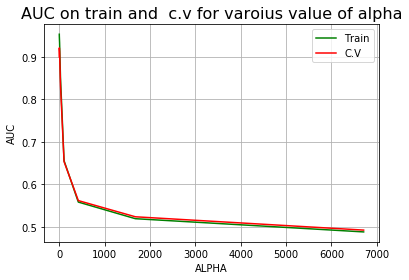

In [202]:
plt.title('AUC on train and  c.v for varoius value of alpha',size=16)
plt.plot(neighbors, auc1,'g',label ='Train')
plt.plot(neighbors, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('ALPHA',size=10)
plt.grid()
plt.legend()
plt.show()


In [203]:
print(neighbors)
print('--------------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------------')

print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

[0.0001, 0.0004, 0.0016, 0.0064, 0.0256, 0.1024, 0.4096, 1.6384, 6.5536, 26.2144, 104.8576, 419.4304, 1677.7216, 6710.8864]
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
[0.953342523190093, 0.9531731332731078, 0.9529357745258284, 0.9525882589173233, 0.9520782455452304, 0.9512504138132211, 0.9497928907904093, 0.946216630522192, 0.9331746134318121, 0.8512260485162714, 0.6555063336836825, 0.5580797023208391, 0.5189109567703689, 0.48778049504723436]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.9000289695698585, 0.9036259577903135, 0.9072953104429815, 0.9107896255407808, 0.9140326554181402, 0.917143287589926, 0.9199406758764413, 0.9212244144138181, 0.9121397792670645, 0.8327803890268608, 0.6533550292501578, 0.5615

In [211]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
mnb = MultinomialNB(alpha =1.6384)

# fitting the model
mnb.fit(Xbow_tr, y_tr)

# predict the response
pred = mnb.predict(Xbow_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the multinomial N.B classifier for alpha = %f is %f%%' % (1.6384, acc))


The accuracy of the multinomial N.B classifier for alpha = 1.638400 is 90.061522%


In [205]:
mnb.classes_

array([0, 1], dtype=int64)

From above we can see that first_class is 0 i.e negative and second_class is 1 i.e positive

###  [5.1.1] Top 10 important features of  negative class from<font color='red'> SET 1</font> are below

In [206]:
# Now we can find log probabilities of different features for both the classes
class_features = mnb.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 10 Important Features and their log probabilities For Negative Class are as follows :\n\n")
for i in list(sorted_negative_features[0:10]):#printing top 10  positive feature one by one
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    


Top 10 Important Features and their log probabilities For Negative Class are as follows :


not	 -->	-3.270101  
like	 -->	-4.400533  
would	 -->	-4.625374  
product	 -->	-4.659083  
taste	 -->	-4.670227  
one	 -->	-4.882864  
coffee	 -->	-5.092174  
good	 -->	-5.115951  
no	 -->	-5.151576  
flavor	 -->	-5.168723  


### [5.1.2] Top 10 important features of positive  class and there log probabilities from<font color='red'> SET 1</font> are below

In [207]:
print("\n\nTop 10 Important Features and their log probabilities For Positive Class are as follows:\n\n")
for i in list(sorted_positive_features[0:10]):#printing top 10  negative feature one by one
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))



Top 10 Important Features and their log probabilities For Positive Class are as follows:


not	 -->	-3.685697  
like	 -->	-4.493285  
good	 -->	-4.620079  
great	 -->	-4.714222  
one	 -->	-4.843267  
taste	 -->	-4.925465  
coffee	 -->	-4.967491  
would	 -->	-5.035174  
love	 -->	-5.043507  
flavor	 -->	-5.044195  


In [208]:
# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (1.6384, acc))

# evaluate precision
acc = precision_score(y_test, pred, pos_label = 1) 
print('\nThe Test Precision of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (1.6384, acc))

# evaluate recall
acc = recall_score(y_test, pred, pos_label = 1)
print('\nThe Test Recall of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (1.6384, acc))

# evaluate f1-score
acc = f1_score(y_test, pred, pos_label = 1)
print('\nThe Test F1-Score of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (1.6384, acc))


The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 1.638 is 90.061522%

The Test Precision of the Multinomial naive Bayes classifier for alpha = 1.638 is 0.942143

The Test Recall of the Multinomial naive Bayes classifier for alpha = 1.638 is 0.939287

The Test F1-Score of the Multinomial naive Bayes classifier for alpha = 1.638 is 0.940713


In [209]:
# Evaluate TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test, pred).ravel()

# Evaluate TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (1.6384,TPR))

# Evaluate FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (1.6384,FPR))

# Evaluate TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (1.6384,TNR))

# Evaluate FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (1.6384,FNR))

TPR of the Multinomial naive Bayes classifier for alpha = 1.638 is :  0.942143
FPR of the Multinomial naive Bayes classifier for alpha = 1.638 is :  0.312456
TNR of the Multinomial naive Bayes classifier for alpha = 1.638 is :  0.687544
FNR of the Multinomial naive Bayes classifier for alpha = 1.638 is :  0.057857


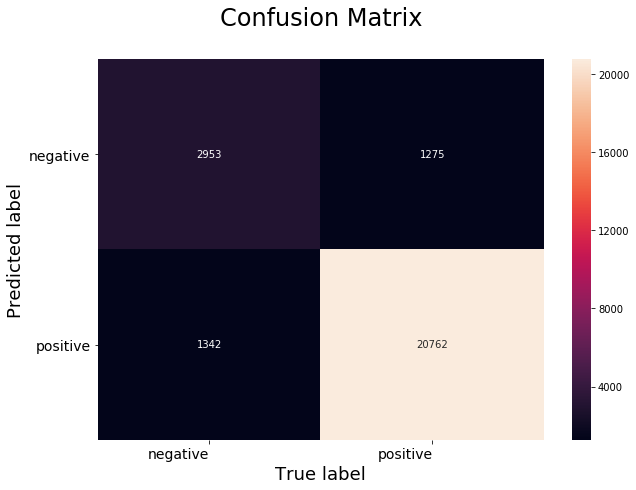

In [210]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### [5.2] Applying Multinomial Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [163]:
count_vect  = TfidfVectorizer(ngram_range=(1,2), min_df=10)

Xbow_tr = count_vect.fit_transform(X_tr)
Xbow_test = count_vect.transform(X_test)
Xbow_cv = count_vect.transform(X_cv)
print("the type of count vectorizer :",type(X_tr))
print("the shape of out text BOW vectorizer : ",Xbow_tr.get_shape())
print("the number of unique words :", Xbow_tr.get_shape()[1])

the type of count vectorizer : <class 'list'>
the shape of out text BOW vectorizer :  (43008, 25713)
the number of unique words : 25713


In [164]:
# Creating alpha values in the range from 10^-4 to 10^4
neighbors = []
i = 0.0001
while(i<=10000):
    neighbors.append(np.round(i,4))
    i *= 4
auc1=[]
auc2=[]

for k in neighbors:
    # instantiate learning model (k)
    mnb = MultinomialNB(alpha = k)

    # fitting the model on crossvalidation train
    mnb.fit(Xbow_tr, y_tr)
    
    probs = mnb.predict_proba(Xbow_tr)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
    #knn.fit(Xbow_cv, y_cv)
    probs = mnb.predict_proba(Xbow_cv)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)

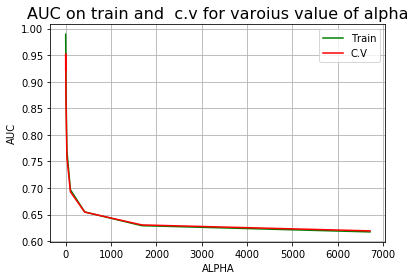

In [165]:
plt.title('AUC on train and  c.v for varoius value of alpha',size=16)
plt.plot(neighbors, auc1,'g',label ='Train')
plt.plot(neighbors, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('ALPHA',size=10)
plt.grid()
plt.legend()
plt.show()


In [190]:
print(neighbors)
print('--------------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------------')

print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

[0.0001, 0.0004, 0.0016, 0.0064, 0.0256, 0.1024, 0.4096, 1.6384, 6.5536, 26.2144, 104.8576, 419.4304, 1677.7216, 6710.8864]
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
[0.989220612293407, 0.9888578554191325, 0.9883258082830697, 0.9875135745824335, 0.9861935896826672, 0.98382657945285, 0.9790443338504735, 0.9665675829593934, 0.8943119408797857, 0.7711899585064064, 0.6969468968270667, 0.6550300396439135, 0.629285877518079, 0.617524056993668]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.9216687796215528, 0.9291851401488125, 0.9364679658342961, 0.9430679698235341, 0.9484699909134502, 0.9520832584269519, 0.9522390420671211, 0.9409668052559119, 0.8696081412993312, 0.7587753610292891, 0.6928426016702965, 0.6548312

In [193]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
mnb = MultinomialNB(alpha =0.4096)

# fitting the model
mnb.fit(Xbow_tr, y_tr)

# predict the response
pred = mnb.predict(Xbow_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the multinomial N.B classifier for alpha = %f is %f%%' % (0.4096, acc))


The accuracy of the multinomial N.B classifier for alpha = 0.409600 is 89.715935%


In [194]:
mnb.classes_

array([0, 1], dtype=int64)


From above we can see that first_class is 0 i.e negative and second_class is 1 i.e positive

### [5.2.1] Top 10 important features of negative class from<font color='red'> SET 2</font> are below

In [195]:
# Now we can find log probabilities of different features for both the classes
class_features = mnb.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 10 Important Features and their log probabilities For Negative Class are as follows :\n\n")
for i in list(sorted_negative_features[0:10]):#printing top 10  positive feature one by one
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    


Top 10 Important Features and their log probabilities For Negative Class are as follows :


not	 -->	-4.878235  
like	 -->	-5.713782  
product	 -->	-5.768676  
would	 -->	-5.809340  
taste	 -->	-5.812911  
coffee	 -->	-6.022713  
one	 -->	-6.125952  
flavor	 -->	-6.250969  
no	 -->	-6.251890  
buy	 -->	-6.364297  


### 5.2.2--> Top 10 Important Features and their log probabilities For Positive Class are as follows:

In [196]:

for i in list(sorted_positive_features[0:10]):#printing top 10  negative feature one by one
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))

not	 -->	-5.280094  
great	 -->	-5.624297  
good	 -->	-5.681381  
like	 -->	-5.734276  
coffee	 -->	-5.776626  
love	 -->	-5.857995  
tea	 -->	-5.869493  
one	 -->	-5.972136  
taste	 -->	-5.978909  
product	 -->	-5.995109  


In [197]:
# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (0.4096, acc))

# evaluate precision
acc = precision_score(y_test, pred, pos_label = 1) 
print('\nThe Test Precision of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (0.4096, acc))

# evaluate recall
acc = recall_score(y_test, pred, pos_label = 1)
print('\nThe Test Recall of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (0.4096, acc))

# evaluate f1-score
acc = f1_score(y_test, pred, pos_label = 1)
print('\nThe Test F1-Score of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (0.4096, acc))


The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 0.410 is 89.715935%

The Test Precision of the Multinomial naive Bayes classifier for alpha = 0.410 is 0.896290

The Test Recall of the Multinomial naive Bayes classifier for alpha = 0.410 is 0.992309

The Test F1-Score of the Multinomial naive Bayes classifier for alpha = 0.410 is 0.941858


In [198]:
# Evaluate TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test, pred).ravel()

# Evaluate TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (0.4096,TPR))

# Evaluate FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (0.4096,FPR))

# Evaluate TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (0.4096,TNR))

# Evaluate FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (0.4096,FNR))

TPR of the Multinomial naive Bayes classifier for alpha = 0.410 is :  0.896290
FPR of the Multinomial naive Bayes classifier for alpha = 0.410 is :  0.091398
TNR of the Multinomial naive Bayes classifier for alpha = 0.410 is :  0.908602
FNR of the Multinomial naive Bayes classifier for alpha = 0.410 is :  0.103710


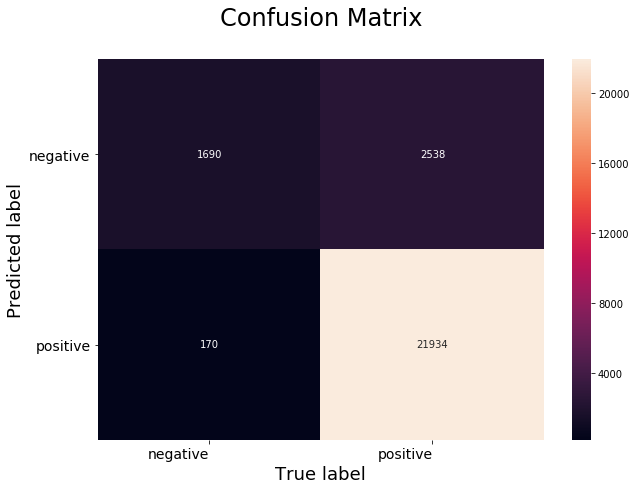

In [199]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# [6] Conclusions

In [213]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vactorizer", "Model", "Hyperparameter(ALPHA)", " AUC%",]

x.add_row(["BOW", "Multinomial N.B", 1.638400, 90.061522])
x.add_row(["TFIDF", "Multinomial N.B",0.409600,89.715935])



print(x)

+------------+-----------------+-----------------------+-----------+
| Vactorizer |      Model      | Hyperparameter(ALPHA) |    AUC%   |
+------------+-----------------+-----------------------+-----------+
|    BOW     | Multinomial N.B |         1.6384        | 90.061522 |
|   TFIDF    | Multinomial N.B |         0.4096        | 89.715935 |
+------------+-----------------+-----------------------+-----------+


 --->>> We have done all below steps for multinomial naive bayes on BOW and TFIDF  VECTORIZERS with 100k points.

STEP 1 :- Data cleaning (removing duplication)

STEP 2 :- Text Preprocessing

STEP 3:- Featurization on text reviews i.e BOW,TFIDF.

STEP 4:-Using AUC as a metric and plot curve for train(predected value on itself) and C.V predected value on train VS for values of ALPHA (10^-4 TO 10^4)in order to find optimal value of alpha .

STEP 5:- Draw "AUC VS ALPHA" plot

STEP 6:- Once , we analise optimal value of optimal value of alpha then train multinomial Naive Bayes again with this optimal alpha and make predictions on test_data.

STEP 7:- Find top 10 values for positive as well as negative class with their log probabilities.

STEP 8:- Evaluate : Accuracy , F1-Score , Precision , Recall , TPR , FPR , TNR , FNR

STEP 9:- Plot Seaborn Heatmap for representation of Confusion Matrix.

AT THE END WE MAKE A TABLE TO COMPAIR OUR RESULTS OF multinomial Naive Bayes WITH DIFFERENT VECTORIZERS with the help of prettytable.